In [ ]:
"""
Pseudocode:

Start with random noise, and use a fully convolutional network to turn into the image
    np meshgrid initialization 2xwxh (fig 22)

Modified UNet (less skip connections, more batch norms...)
    leaky relu
    downsample with just conv (stride=1)
    upsample with bilinear / NN
    reflection padding
    leakyrelu with 0.2 negative slope

inpainting vase
    nu = nd = [128, 128, 128, 128, 128]
    ku = kd = [3, 3, 3, 3, 3]
    ns = [4, 4, 4, 4, 4]
    ks = [1, 1, 1, 1, 1]
    sigma_p = 1/30
    num_iter = 5000
    LR = 0.01
    upsampling = bilinear
    
inpainting staircase
    input is 32 x w x h ~ U[0, 0.1]
    nu = nd = [16, 32, 64, 128, 128]
    ku = [3, 3, 3, 3, 3, 3]
    kd = [5, 5, 5, 5, 5, 5]
    NO SKIP CONNECTIONS
    ns = [0, 0, 0, 0, 0, 0]
    ks = [NA, NA, NA, NA, NA, NA]
    sigma_p = 0
    num_iter = 5000
    LR = 0.01
    upsampling = NN
    
denoising
    input is 32 x w x h ~ U[0, 0.1]
    nu = nd = [128, 128, 128, 128, 128]
    ku = kd = [3, 3, 3, 3, 3]
    ns = [4, 4, 4, 4, 4]
    ks = [1, 1, 1, 1, 1]
    sigma_p = 1/30
    num_iter = 1800
    LR = 0.01
    upsampling = bilinear
    
Loss: MSE of pixels
    Only the unmasked pixels in inpainting
    go back if loss diff between two consecutive iterations greater than thres
Opt: ADAM
Calculate PSNR against noisy and gt

Also can average over restored with exp mvg

Noise regularization
Loss backtracking
"""

In [97]:
import numpy as np
from PIL import Image
import torchvision
import torch
import torch.nn as nn
import time
from skimage.measure import compare_psnr
from IPython.display import display # to display images

In [208]:
def make_d_module(in_channels, n, k):
    padding_size = int((k-1)/2)
    return nn.Sequential(
        nn.Conv2d(in_channels, n, (k, k), stride=2,
                  padding = padding_size, padding_mode='reflect'),
        nn.BatchNorm2d(n),
        nn.LeakyReLU(negative_slope=0.2, inplace=True),
        nn.Conv2d(n, n, (k, k), stride=1,
                  padding = padding_size, padding_mode='reflect'),
        nn.BatchNorm2d(n),
        nn.LeakyReLU(negative_slope=0.2, inplace=True)
    )
def make_u_module(in_channels, n, k, upsampling_type, use_depthwise_conv):
    padding_size = int((k-1)/2)
    modules = [
        nn.BatchNorm2d(in_channels),
        nn.Conv2d(in_channels, n, (k, k), stride=1,
                  padding = padding_size, padding_mode='reflect'),
        nn.BatchNorm2d(n),
        nn.LeakyReLU(negative_slope=0.2, inplace=True),
    ]
    if use_depthwise_conv:
        modules.extend([
            nn.Conv2d(n, n, 1, stride=1,
                      padding = 0),
            nn.BatchNorm2d(n),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
        ])
    modules.append(nn.Upsample(scale_factor=2, mode=upsampling_type))
    return nn.Sequential(*modules)

def make_s_module(in_channels, n, k):
    padding_size = int((k-1)/2)
    return nn.Sequential(
        nn.Conv2d(in_channels, n, (k, k), stride=1,
                  padding = padding_size, padding_mode='reflect'),
        nn.BatchNorm2d(n),
        nn.LeakyReLU(negative_slope=0.2, inplace=True),
    )

class DIP(nn.Module):
    def __init__(self, input_depth, nu, nd, ku, kd, ns, ks, upsampling_type,
                 use_depthwise_conv):
        super(DIP, self).__init__()
        self.d_modules = []
        self.u_modules = []
        self.s_modules = []
        
        if len(ks) > 0 and ks[0] != None:
            self.use_skips = True
        else:
            self.use_skips = False
        
        for i in range(len(nd)):
            if i == 0:
                self.d_modules.append(make_d_module(input_depth, nd[i], kd[i]))
            else:
                self.d_modules.append(make_d_module(nd[i-1], nd[i], kd[i]))

            if self.use_skips:
                self.s_modules.append(make_s_module(nd[i], ns[i], ks[i]))
            u_in_channels = None
            if i == len(nd) - 1:
                if self.use_skips:
                    u_in_channels = ns[i]
                else:
                    u_in_channels = nd[i]
            else:
                u_in_channels = ns[i] + nu[i+1]

            self.u_modules.append(
                make_u_module(u_in_channels, nu[i], ku[i], upsampling_type,
                              use_depthwise_conv))
        
        self.d_modules = nn.ModuleList(self.d_modules)
        self.u_modules = nn.ModuleList(self.u_modules)
        if self.use_skips:
            self.s_modules = nn.ModuleList(self.s_modules)
        self.final_conv = nn.Conv2d(nu[0], 3, 1, stride=1,
            padding = 0)
            
    def forward(self, x):
        
        skip_xs = []
        for i in range(len(self.d_modules)):
            x = self.d_modules[i](x)
            if self.use_skips:
                skip_xs.append(self.s_modules[i](x))
        for i in range(len(self.u_modules) - 1, -1, -1):
            if self.use_skips:
                if i == len(self.u_modules) - 1:
                    x = skip_xs.pop()
                else:
                    x = torch.cat((x, skip_xs.pop()), dim=1)
            x = self.u_modules[i](x)
        x = self.final_conv(x)
        x = torch.sigmoid(x)
        return x

In [200]:
network_name = "inpainting_library"

# defaults
nu = nd = [128, 128, 128, 128, 128]
ku = kd = [3, 3, 3, 3, 3]
ns = [4, 4, 4, 4, 4]
ks = [1, 1, 1, 1, 1]
upsampling_type = 'bilinear'
param_noise = False
use_depthwise_conv = True

input_depth = 32
lr = 0.01
batch_size = 1
sigma_p = 1/30
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:', str(device))
num_iter = 2000

is_input_meshgrid = False

if network_name == "denoising":
    num_iter = 1800
elif network_name == "inpainting_library":
    nu = nd = [16, 32, 64, 128, 128, 128]
    ku = [3] * 6
    kd = [5] * 6
    ns = [0] * 6
    ks = [None] * 6
    sigma_p = 0
    num_iter = 5000
    upsampling_type = 'nearest'
    lr = 0.1
    param_noise = True
    use_depthwise_conv = False
    input_depth = 1
elif network_name in "inpainting_vase":
    ns = [0] * 6
    ks = [None] * 6
    num_iter = 5000
    upsampling_type = 'nearest'
    input_meshgrid = True
elif network_name == "inpainting_vase_overexposed":
    ns = [0] * 6
    ks = [None] * 6
    num_iter = 5000
    input_meshgrid = True
elif network_name == "inpainting_library_overexposed":
    nu = nd = [16, 32, 64, 128, 128, 128]
    ku = [3] * 6
    kd = [5] * 6
    ns = [0] * 6
    ks = [None] * 6
    sigma_p = 0
    num_iter = 5000
    upsampling_type = 'nearest'
    lr = 0.1
    param_noise = True
    use_depthwise_conv = False
    input_depth = 1

if is_input_meshgrid:
    input_depth = 2

device: cuda


In [201]:
(np.array([[1,2,3], [1,2,4]]) == np.array([[1,2,3]])).all(axis=1).astype(int)

array([1, 0])

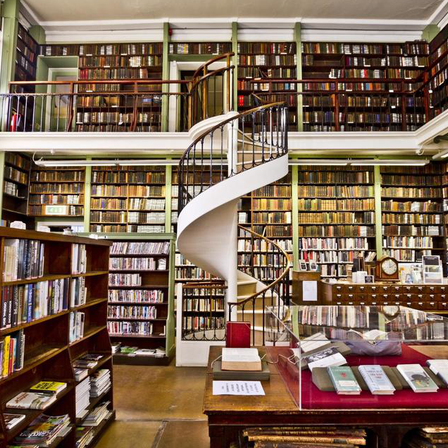

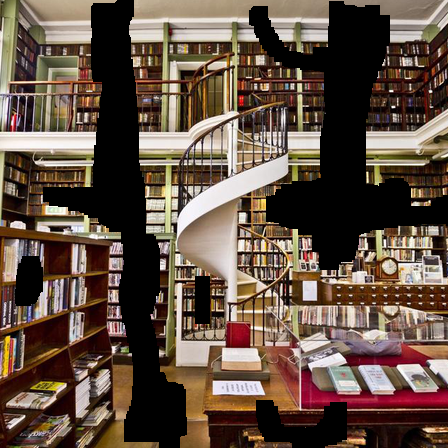

torch.Size([1, 1, 448, 448]) (448, 448, 3) torch.Size([1, 3, 448, 448])


In [203]:
def center_crop(im):
    # Copied from here: https://stackoverflow.com/questions/16646183/crop-an-image-in-the-centre-using-pil
#     print(im.size)
    width, height = im.size   # Get dimensions
    new_height = new_width = min(width, height)
    left = (width - new_width)/2
    top = (height - new_height)/2
    right = (width + new_width)/2
    bottom = (height + new_height)/2

    # Crop the center of the image
    im = im.crop((left, top, right, bottom))
    return im

def gamma_decode_image(pil_img) -> np.ndarray:
    '''
    Read a PNG or JPG image an array of linear RGB radiance values ∈ [0,1].
    '''
    return (np.float32(pil_img) / 255)**2.2


def gamma_encode_image(image: np.ndarray) -> None:
    '''
    Write an array of linear RGB radiance values ∈ [0,1] as a PNG or JPG image.
    '''
    return np.uint8(255 * image.clip(0, 1)**(1/2.2))

# img_path = 'data/denoising/F16_GT.png'
img_path = 'data/inpainting/library.png'
mask_path = 'data/inpainting/library_mask.png'
pil_img = center_crop(Image.open(img_path))
orig_np_img = np.array(pil_img)

# Alter image
if network_name == "denoising":
    sigma_noise = 25
    np_img = np.random.randn(*orig_np_img.shape) * sigma_noise + orig_np_img
    np_img = np.clip(np_img, 0, 255) / 255
elif "exposed" in network_name:
    pil_img = center_crop(Image.open(img_path))
    orig_np_img = np.array(pil_img)
    decoded_img = gamma_decode_image(pil_img)
    decoded_img *= 1.5
    pixel_filter = np.array([255, 255, 255]).reshape(1, 1, 3)
    # Get all overexposed pixels
    mask_img = (gamma_encode_image(decoded_img) != pixel_filter).all(
        axis=2).astype(np.uint8)[..., np.newaxis]
    np_img = mask_img * orig_np_img
    np_img = np.clip(np_img, 0, 255) / 255
    torch_mask = torch.Tensor(np.swapaxes(mask_img, 0, 2)).unsqueeze(0).to(device)
    
elif "inpainting" in network_name:
    mask_img = np.array(center_crop(Image.open(mask_path)))[..., np.newaxis] / 255
    np_img = mask_img * orig_np_img
    np_img = np.clip(np_img, 0, 255) / 255
    torch_mask = torch.Tensor(np.swapaxes(mask_img, 0, 2)).unsqueeze(0).to(device)
    
display(Image.fromarray((orig_np_img).astype(np.uint8)))
display(Image.fromarray((np_img * 255).astype(np.uint8)))

orig_np_y = np.swapaxes(orig_np_img, 0, 2)
np_y = np.swapaxes(np_img, 0, 2)
y_nonreg = torch.Tensor(np_y).unsqueeze(0).to(device)


img_size = np_img.shape[0]

if is_input_meshgrid:
    vec = torch.linspace(0, 1, img_size)
    x = torch.empty((1, 2, img_size, img_size))
    grid_x, grid_y = torch.meshgrid(x, x)
    x[0, 0] = grid_x
    x[0, 1] = grid_y
else:
    x = torch.rand((1, input_depth, img_size, img_size)) / 10
x = x.to(device)

print(x.shape, np_img.shape, y_nonreg.shape)

In [209]:
model = DIP(input_depth, nu, nd, ku, kd, ns, ks, upsampling_type,
            use_depthwise_conv).to(device)

In [210]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
prev_psnr = None
prev_weights = None
start_time = time.time()
show_interval = 100
save_interval = 250

In [211]:
def pred_to_pil(y_pred):
    np_pred = np.clip(np.swapaxes(
        (y_pred.cpu().detach().numpy() * 255)[0],
        0, 2
    ).astype(np.uint8), 0, 255)
    pil_pred = Image.fromarray(np_pred)
    return pil_pred

<ipython-input-212-b3e2b858f22b>:23: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  psnr = compare_psnr(orig_np_y, raw_y_pred.detach().cpu().numpy()[0])


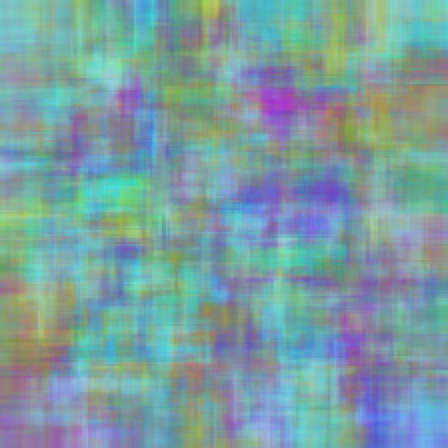

Epoch: 0, loss: 0.1026715338230133, psnr: 5.962694358902445, time taken: 1.2403087615966797


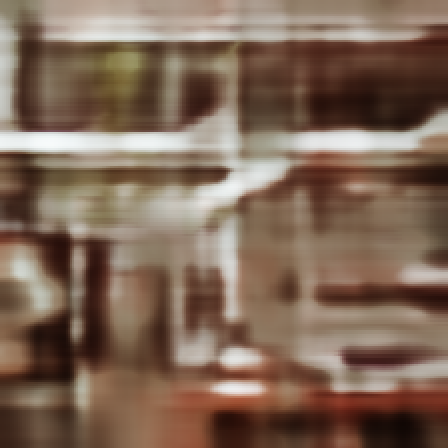

Epoch: 100, loss: 0.030815089121460915, psnr: 5.959832333968446, time taken: 12.976588726043701


In [ ]:
version_num = 2
for t in range(2000):
    if param_noise:
        for n in [x for x in model.parameters() if len(x.size()) == 4]:
            n = n + n.detach().clone().normal_() * n.std() / 50

    raw_y_pred = model(x)
    
    # Prepare gt image
    if sigma_p != 0:
        noise = (torch.randn(y_nonreg.shape) * sigma_p).to(device)
        y = torch.clip(y_nonreg + noise, 0, 1)
    else:
        y = y_nonreg

    if "inpainting" in network_name:
#         print(y_pred.shape, torch_mask.shape)
        y_pred = torch_mask * raw_y_pred
    else:
        y_pred = raw_y_pred

    loss = criterion(y_pred, y)
    psnr = compare_psnr(orig_np_y, raw_y_pred.detach().cpu().numpy()[0])
    
    optimizer.zero_grad()

    if t % show_interval == 0:
        pil_pred = pred_to_pil(raw_y_pred)
        display(pil_pred)
        pil_pred.save("{}_epoch_{}_version_{}.png".format(
            network_name, t, version_num))
        print("Epoch: {}, loss: {}, psnr: {}, time taken: {}".format(
            t, loss.item(), psnr, time.time() - start_time))
        start_time = time.time()
        
        # Copied from DIP repo as alas - this is no task for mere mortals
        if prev_psnr is None or psnr > prev_psnr - 5:
            prev_weights = [p.detach().cpu() for p in model.parameters()]
            prev_psnr = psnr
        else:
            print("Backtracking")
            for new_param, net_param in zip(prev_weights, model.parameters()):
                net_param.data.copy_(new_param.cuda())
            continue

    loss.backward()
    optimizer.step()
    if t % save_interval == save_interval - 1:
        torch.save(model.state_dict(),
            "{}_epoch_{}_version_{}".format(network_name, t, version_num))

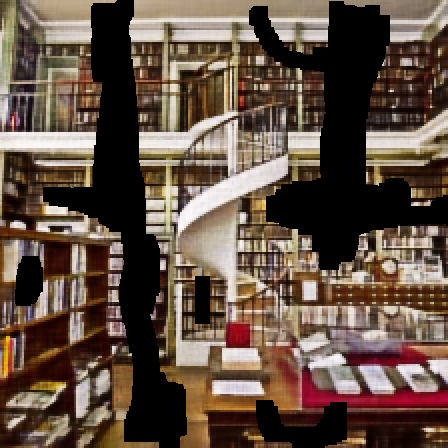

In [160]:
display(pred_to_pil(y_pred))

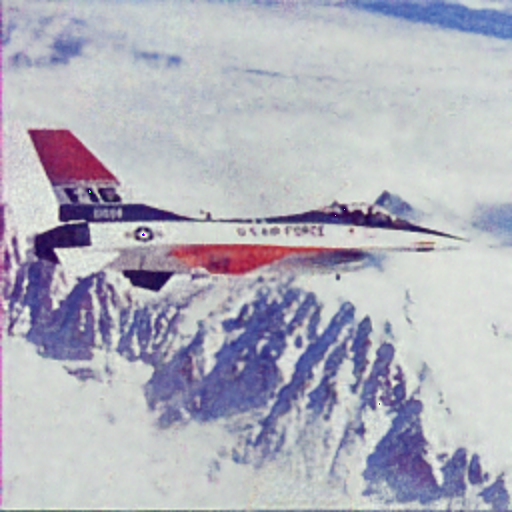

In [105]:
display(pred_to_pil(y_pred))

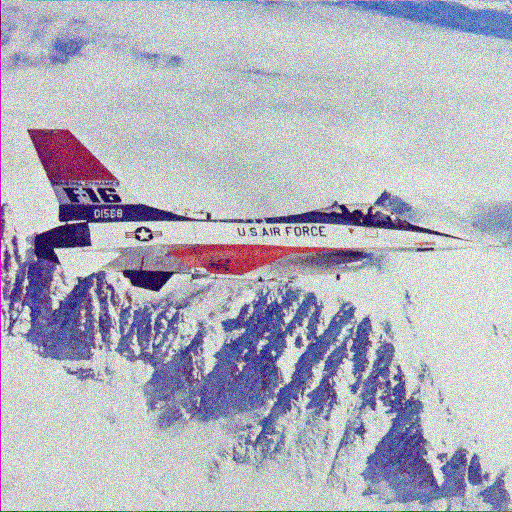

In [94]:
display(Image.fromarray((np_img * 255).astype(np.uint8)))